In [67]:
import pandas as pd
import os
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from matplotlib.ticker import ScalarFormatter
font = {'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

### Get initial distributions

In [68]:
# Target Variable
y = pd.DataFrame.from_dict(np.load(os.path.join("..", "data", "npys_data", "target_croplands.npy"), allow_pickle=True), orient="columns")
y = y["Target"].astype(int).to_numpy()
# Set classes 4,5 to 0
y = np.where(y > 3, 0, y)

# count number of pixels and save in df
class_counts = Counter(y)
initial_distribution_df = pd.DataFrame([class_counts], index=['initial_distribution']).rename(columns=lambda x: f"class{x}")
initial_distribution_df = initial_distribution_df[['class0', 'class1', 'class2', 'class3']]

### Get predictions made by lstm model for 2030 and 2050 years

In [73]:
# Define the directory where the .npy files are located
directories = {"2020_2030": os.path.join("..", "results", "2020_2030"),
               "2040_2050": os.path.join("..", "results", "2040_2050"),
}

# Define an empty dictionary to store the DataFrames
results_dfs = {}
    
for key, item in directories.items():
    # Define a temp dictionary to store the results
    results = {}

    # Loop over the files in the directory
    for file in os.listdir(directories[key]):
        if file.endswith('.npy') and "average" in file and 'lstm' in file: 

            # Load the .npy file as a numpy array
            array = np.load(os.path.join(directories[key], file), allow_pickle=True)

            # Extract the model, scenario, and climatic parameter from the filename
            model, scenario, climatic_parameter = file.split('_')[:3]

            # Convert the numpy array to a pandas DataFrame
            df = pd.DataFrame(array, columns=[f'class{i}' for i in range(array.shape[1])])

            # Count the number of samples belonging to each class
            counts = df.apply(lambda x: sum(x), axis=0)

            # Add the counts to the results dictionary, using the model name as the key
            if model not in results:
                results[model] = {}
            results[model][f'{scenario}_{climatic_parameter}'] = counts

    # Loop over the models in the results dictionary
    for model, results in results.items():
        # Create a DataFrame with the counts from the results dictionary
        df = pd.DataFrame(results).transpose()

        # Add the DataFrame to the model_dfs dictionary, using the model name as the key
        results_dfs[key] = df

### plot results

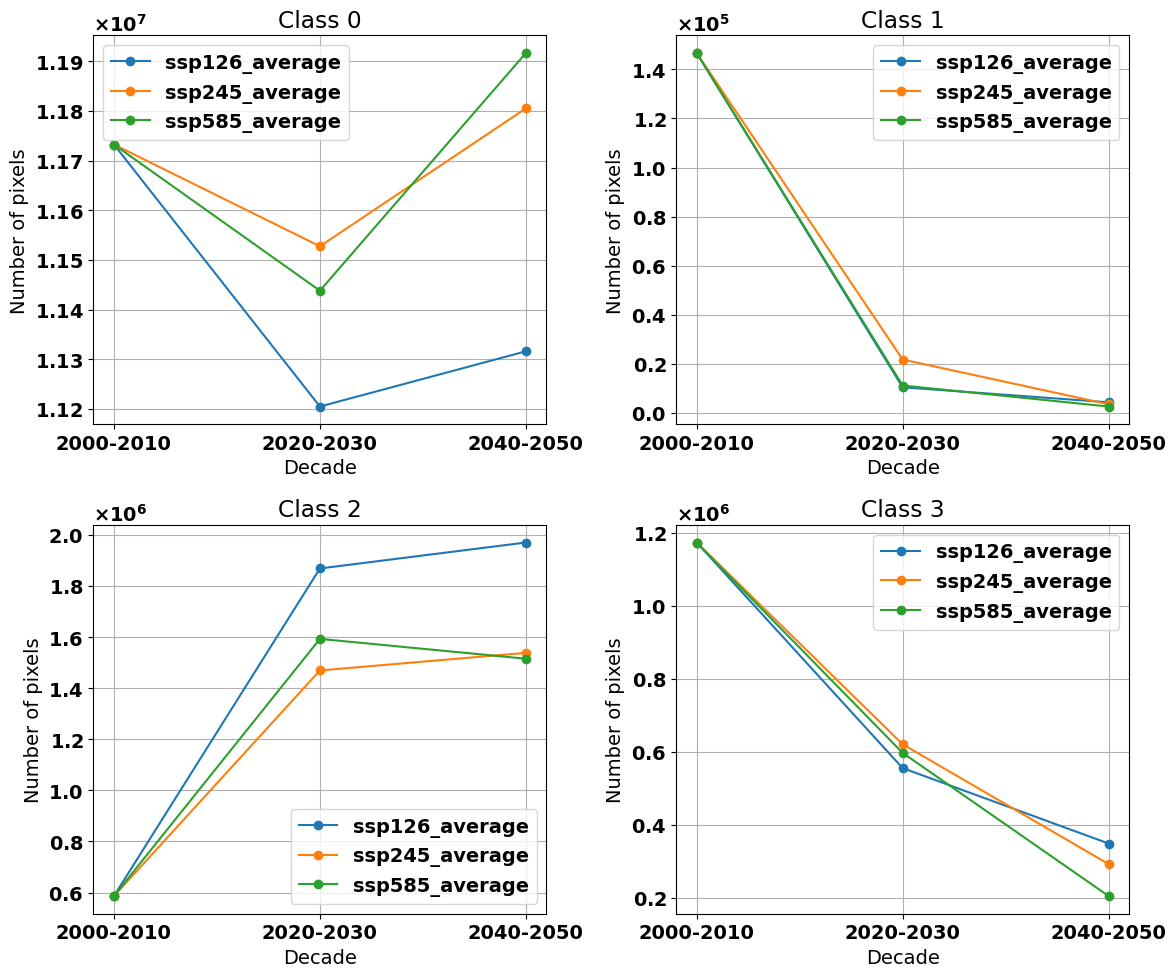

In [74]:
# Set up the plot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axs = axs.ravel()

# Loop over each class and plot the curves
for i, class_name in enumerate(initial_distribution_df.columns):
    # Get the data for this class
    init_data = initial_distribution_df.loc['initial_distribution', class_name]
    data_2020_2030 = results_dfs['2020_2030'].loc[:, class_name].values
    data_2040_2050 = results_dfs['2040_2050'].loc[:, class_name].values

    # Plot the curves
    for j in range(3):
        axs[i].plot([0, 1, 2], [init_data, data_2020_2030[j], data_2040_2050[j]], marker='o', label=results_dfs['2020_2030'].index[j])
    axs[i].set_title(f'Class {i}')
    axs[i].set_xlabel('Decade')
    axs[i].set_ylabel('Number of pixels')
    axs[i].set_xticks([0, 1, 2])
    axs[i].set_xticklabels(['2000-2010', '2020-2030', '2040-2050'])
    axs[i].legend()
    axs[i].grid()

    # Force y-axis to use scientific notation
    axs[i].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.tight_layout()
plt.show()